### 필요한 라이브러리 불러오기

In [1]:
import cv2
import os, glob
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib
import urllib
from PIL import Image

from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np

import tensorflow as tf
from PIL import Image

### DeepLab 모델

In [2]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
            tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map# 배경과 원본 이미지 합성하기
# 앞에서 segementation 작업을 통해 이미 만들어둔 고양이 사진에 수영장 이미지를 합성합니다.



### 사진 불러오기

이미지 크기: (1440, 1080, 3)


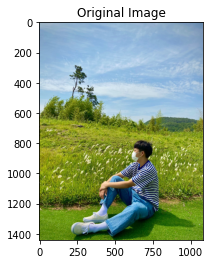

In [3]:
import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/img.png'  # 본인이 사용할 사진의 경로
img_orig = cv2.imread(img_path)
print("이미지 크기:", img_orig.shape)

img_rgb = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.title('Original Image')

plt.show()

### 사전에 학습된 가중치(pretrained weight) 불러오기

In [4]:
# deeplabv3_mnv2_pascal_train_aug_2018_01_29 weight 다운로드
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

# DeepLabModel 초기화
MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /aiffel/aiffel/human_segmentation/models
model loaded successfully!


In [5]:
# 첫 단계에서 준비한 이미지를 네트워크에 입력합니다.
img_resized, seg_map = MODEL.run(img_orig)
print(img_orig.shape, img_resized.shape, seg_map.max())

(1440, 1080, 3) (513, 384, 3) 15


In [6]:
# DeepLab 에서 제공하는 라벨 종류는 아래와 같습니다.
LABEL_NAMES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 
               'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 
               'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv']
len(LABEL_NAMES)

21

### 세그멘테이션 결과 보기

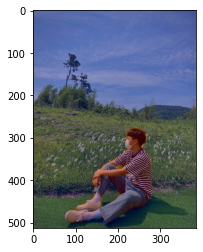

In [7]:
# 사람 라벨을 가진 영역만 검출하기
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0)  # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max())  # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### 세그멘테이션 결과를 원래 크기로 복원하기

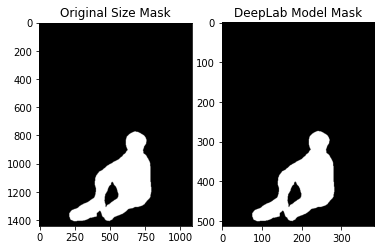

In [8]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

### 배경 흐리게 하기

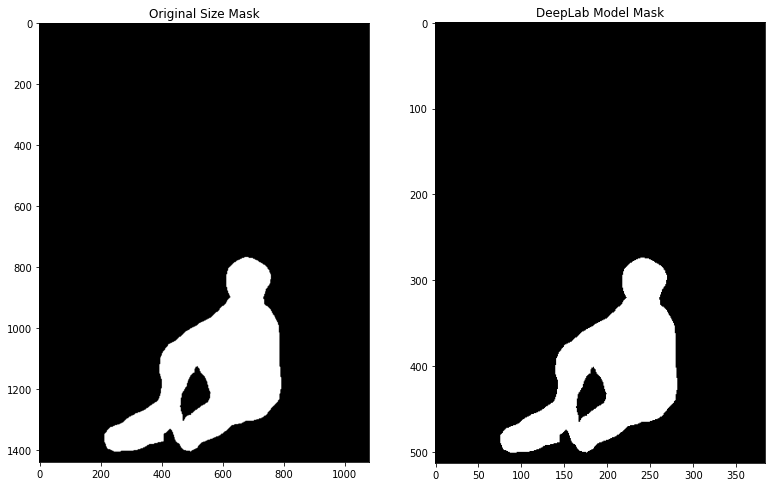

In [9]:
# interpolation(보간법) : 이미지의 크기(scaling)를 변경하는 하는 과정에서 컴퓨터가 사이사이 픽셀값을 채우는 방법
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)  

# 결과적으로 img_mask_up은 경계가 블러된 픽셀값 0~255의 이미지를 얻는다.
# 확실한 경계를 다시 정하기 위해 중간값이 128을 기준으로 임계값(threshold)을 설정합니다.
# 128 이하의 값은 0으로, 128 이상의 값은 255로 만들어준다.
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

plt.figure(figsize=(13,13))

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

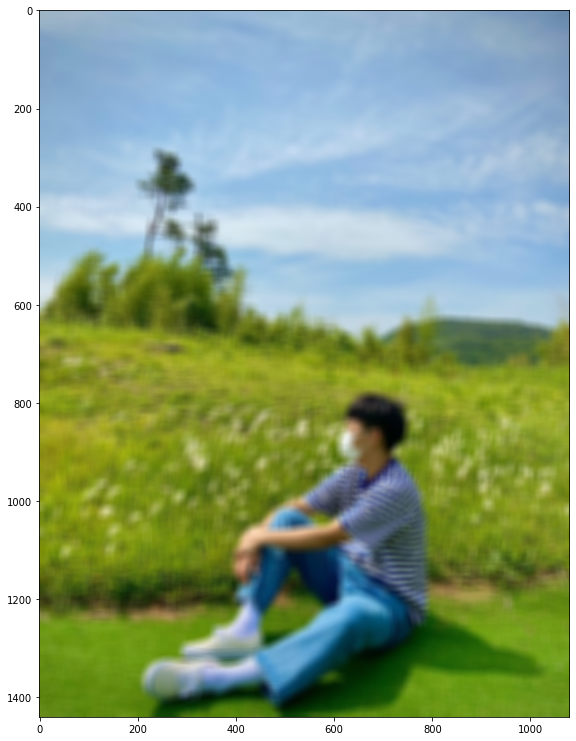

In [10]:
# blur() 함수 이용
img_orig_blur = cv2.blur(img_orig, (13,13))  # (13,13)은 blurring  kernel size를 뜻합니다. 
img_orig_blur2 = cv2.blur(img_orig, (20,20))  # blurring  kernel size를 (20,20)으로 만들어서 (13,13)과 차이를 확인해봅니다. 


plt.figure(figsize=(13,13))


plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))



plt.imshow(cv2.cvtColor(img_orig_blur2, cv2.COLOR_BGR2RGB))


plt.show()


### 배경만 추출

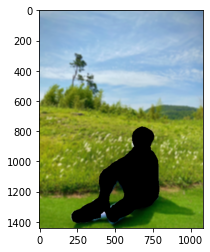

In [11]:
# 흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출하겠습니다.
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)  # bitwise_not 함수를 이용하면 이미지가 반전된다.(배경은 255, 사람은 0)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)  # 반전된 세그멘테이션 결과를 이용해 이미지와 bitwise_and 연산을 수행하면 배경만 있는 영상을 얻을 수 있게 된다.

plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))

plt.show()

### 흐린 배경과 원본사진 합성

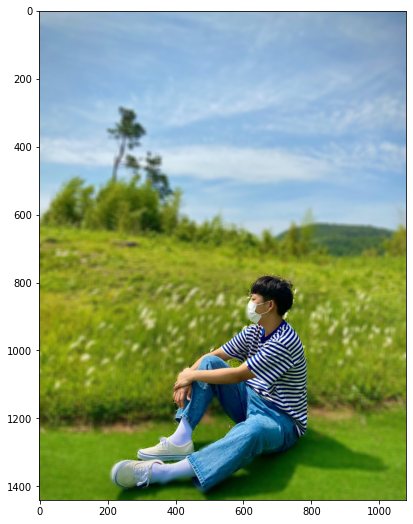

In [12]:
# 배경 이미지와 인물 이미지를 합쳐준다.
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)  # 마스크에서 255인 부분(사람)은 img_orig, 아닌 부분은 img_bg_blur 를 사용

plt.figure(figsize=(9,9))

plt.imshow(img_rgb)


plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))


plt.show()

### 고양이 사진 불러오기

(324, 600, 3)


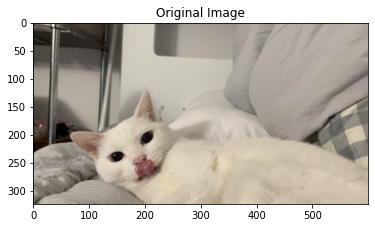

In [13]:
cat_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat_img.png'  # 사용할 사진의 경로
cat_img_orig = cv2.imread(cat_img_path)
print(cat_img_orig.shape)

cat_img_rgb = cv2.cvtColor(cat_img_orig, cv2.COLOR_BGR2RGB)
plt.imshow(cat_img_rgb)
plt.title('Original Image')
plt.show()

In [14]:
cat_img_resized, seg_map = MODEL.run(cat_img_orig)
print(cat_img_orig.shape, cat_img_resized.shape, seg_map.max()) 

(324, 600, 3) (277, 513, 3) 8


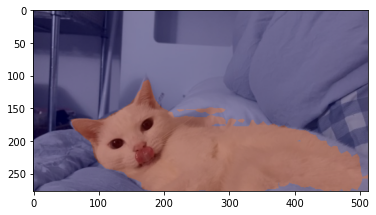

In [15]:
# 고양이만 추출 해보기
img_show = cat_img_resized.copy()
seg_map = np.where(seg_map == 8, 8, 0)  # 예측 중 고양이만 추출
img_mask = seg_map * (255/seg_map.max())  # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### 세그멘테이션 결과를 원래 크기로 복원

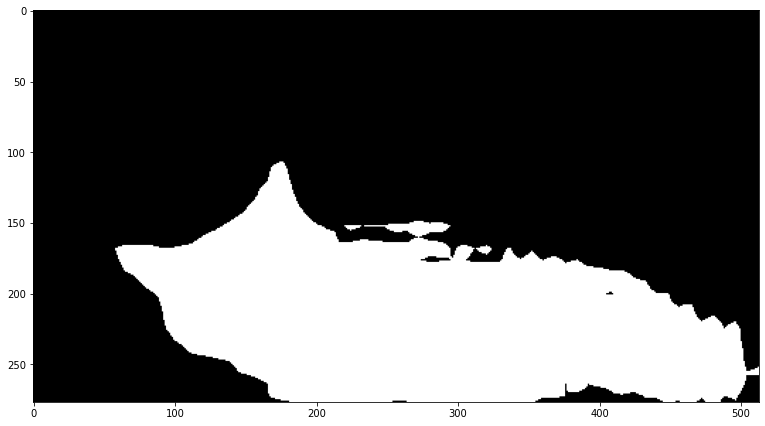

In [16]:
img_mask_up = cv2.resize(img_mask, cat_img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)  
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

plt.figure(figsize=(13,13))

plt.imshow(img_mask_up, cmap=plt.cm.binary_r)



plt.imshow(img_mask, cmap=plt.cm.binary_r)


plt.show()

### 사진 흐리게 만들기

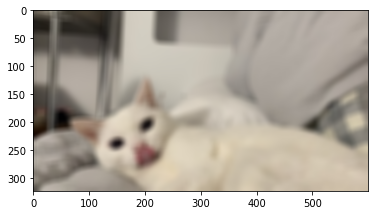

In [17]:
# blur() 함수 이용
cat_img_orig_blur = cv2.blur(cat_img_orig, (13,13))  #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(cat_img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

### 배경만 추출하기

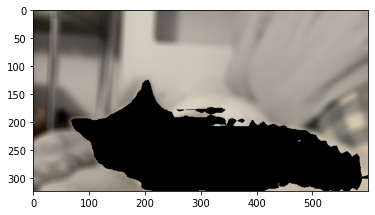

In [18]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(cat_img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

### 원본사진 합성하기

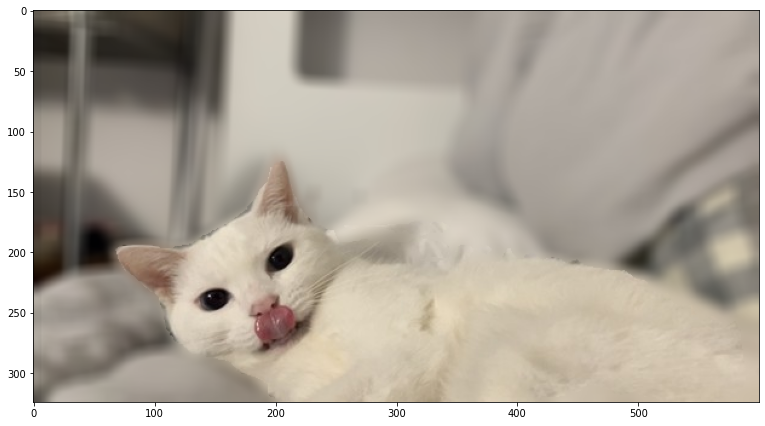

In [19]:
img_concat2 = np.where(img_mask_color==255, cat_img_orig, img_bg_blur)

plt.figure(figsize=(13,13))
plt.imshow(cat_img_rgb)
plt.imshow(cv2.cvtColor(img_concat2, cv2.COLOR_BGR2RGB))

plt.show()

### 크로마키 사진 불러오기

(683, 620, 3)


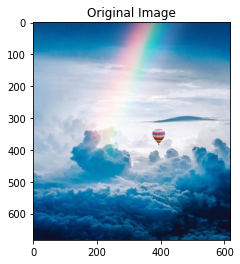

In [20]:
bg_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/background_img.png'  # 본인이 사용할 사진의 경로                       
bg_img_orig = cv2.imread(bg_img_path)
print(bg_img_orig.shape)

bg_img_rgb = cv2.cvtColor(bg_img_orig, cv2.COLOR_BGR2RGB)
plt.imshow(bg_img_rgb)
plt.title('Original Image')
plt.show()

### 크로마키 사진과 합성할 사진 불러오기

(324, 600, 3)


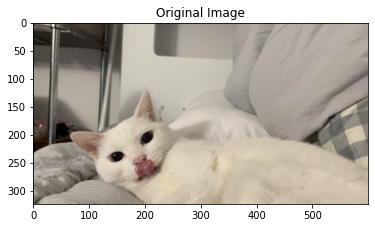

In [21]:
cat_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat_img.png'  # 본인이 사용할 사진의 경로
cat_img_orig = cv2.imread(cat_img_path)
print(cat_img_orig.shape)

cat_img_rgb = cv2.cvtColor(cat_img_orig, cv2.COLOR_BGR2RGB)
plt.imshow(cat_img_rgb)
plt.title('Original Image')
plt.show()

### 배경 이미지와 고양이 이미지 사이즈 맞춰주기

In [22]:
target_size = (cat_img_orig.shape[1], cat_img_orig.shape[0])
bg_resized = cv2.resize(bg_img_orig, target_size)  # 배경 이미지를 target size 크기로 resize 합니다.

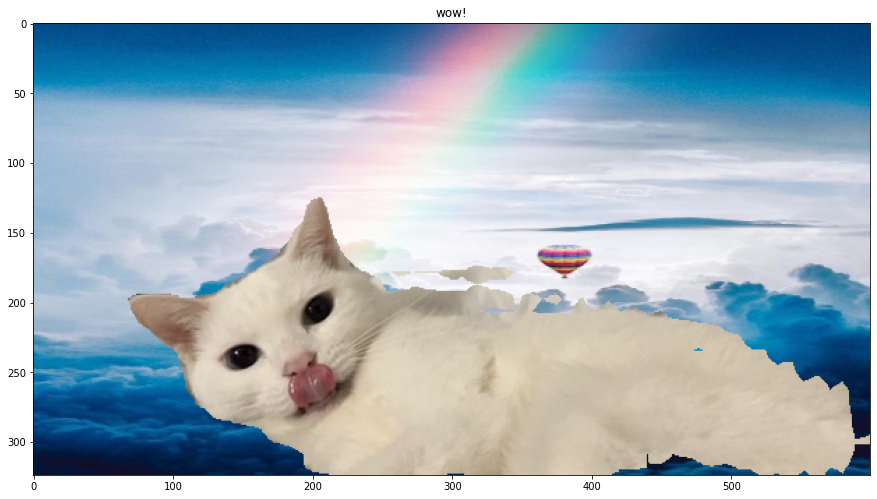

In [27]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_concat3 = np.where(img_mask_color==255, cat_img_orig, bg_resized)

plt.figure(figsize=(15,15))
plt.imshow(cv2.cvtColor(img_concat3, cv2.COLOR_BGR2RGB))
plt.title("wow!")
plt.show()

### 결과물

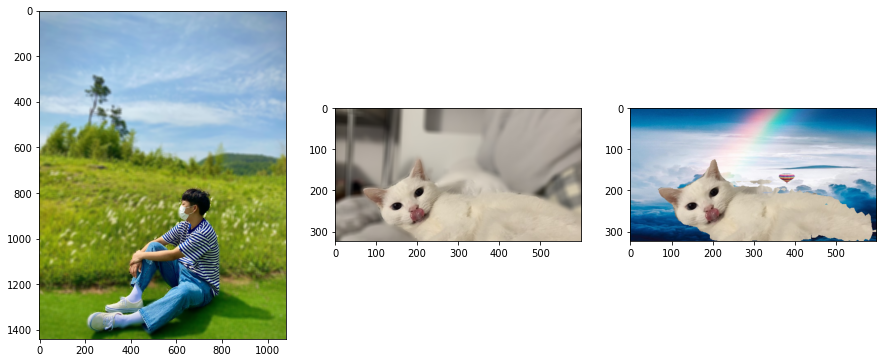

In [26]:
plt.figure(figsize=(15,15))

plt.subplot(1,3,1)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))


plt.subplot(1,3,2)
plt.imshow(cv2.cvtColor(img_concat2, cv2.COLOR_BGR2RGB))


plt.subplot(1,3,3)
plt.imshow(cv2.cvtColor(img_concat3, cv2.COLOR_BGR2RGB))


plt.show()

# 회고

#### 이번 프로잭트를 솔직히 초반부분 진행하면서 노드에 있는 코드들을 참고 하면서 하면 진행이 돼서 쉽다고 생각했었는데                                        점점 하다보니까 잘못된 생각이라는걸 느꼈습니다. 바로 크로마키 사진 합성할때 어렵다고 느껴졌는데 그 이유는 계속 두 사진의                            크기를 맞춰주려고 resize를 해줘야했고 cv2로 진행을 하다보니까 계속 에러가 떠서 plt로 또 바꿔서 진행했는데                                                    계속 오류가 떠서 방법을 찾던중에 그냥 바로 배경 이미지를 타겟 이미지 사이즈에 맞출수있는 방법을 찾아서 적용해서 진행했습니다.

## 문제점

#### 위에 결과물에서 보면 첫번째 사진의 문제점은 blur 처리된 경계 부분이 깔끔하지 못하기 때문에 그 따로 그 부분들을 확대시켜                              blur처리 한뒤에 다시 이미지 합성을 해준다면 쫌더 깔끔하게 처리될것같다.

#### 두번째 사진의 문제점은 blur처리한 경계가 확실하지 않고 배경에 흰색 이불이 고양이 털로 인식 되는 문제점을 발견했는데 이 부분은 해결            책을 찾지 못했습니다.

#### 세번째 사진 역시 두번째 사진과 같은 문제점이 발생했는데 배경의 색 차이 때문인지 3번째 사진에서 더욱 선명하게 문제점을 확인 할수 있            습니다.